# I was given the task of predicting what causes the spread of Dengue fever for San Juan, Puerto Rico and Iquitos, Peru and if the data could be separated between the two cities.

In [1]:
#Symptoms of dengue fever usually start three to fourteen day after infection
#Two to seven days to recover
#Spread by several species of female mosquitos
#Early detection lowers fatality rate
#The time it takes from ingesting the virus to actual transmission to a new host is termed the extrinsic incubation period(EIP) 
#The EIP takes about 8-12 days when the ambient temperature is between 25-28°C 
#https://www.who.int/news-room/fact-sheets/detail/dengue-and-severe-dengue

In [2]:
from arcgis.gis import *

In [3]:
gis = GIS()
map = gis.map('San Juan',10, mode='3D')
map

MapView(layout=Layout(height='400px', width='100%'), mode='3D', zoom=10.0)

In [4]:
map2 = gis.map('Iquitos', 7.5, mode='3D')
map2

MapView(layout=Layout(height='400px', width='100%'), mode='3D', zoom=7.5)

In [5]:
#These first 4 packages are for basic data exploration and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#This next package is to prepare the data for the machine learning model
import sklearn.preprocessing 
#The next two lines of code set the style and size for my charts
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
#This is so my charts will show in the jupyter notebook
%matplotlib inline

In [6]:
df = pd.read_csv('dengue_features_train.csv')
target = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')
df['total_cases'] = target['total_cases']

In [7]:
#Creating dataframes for each city
#Filling all the null value with the forward fill method
#And dropping city, year, and week_start_date because they won't be useful for predicting what causes dengue fever
sj = df[df['city'] == 'sj']
iq = df[df['city'] == 'iq']

In [8]:
sj = sj.fillna(method = 'ffill')
iq = iq.fillna(method = 'ffill')

In [9]:
sj.drop(['city', 'year', 'week_start_date'], axis=1, inplace=True)
iq.drop(['city', 'year', 'week_start_date'], axis=1, inplace=True)

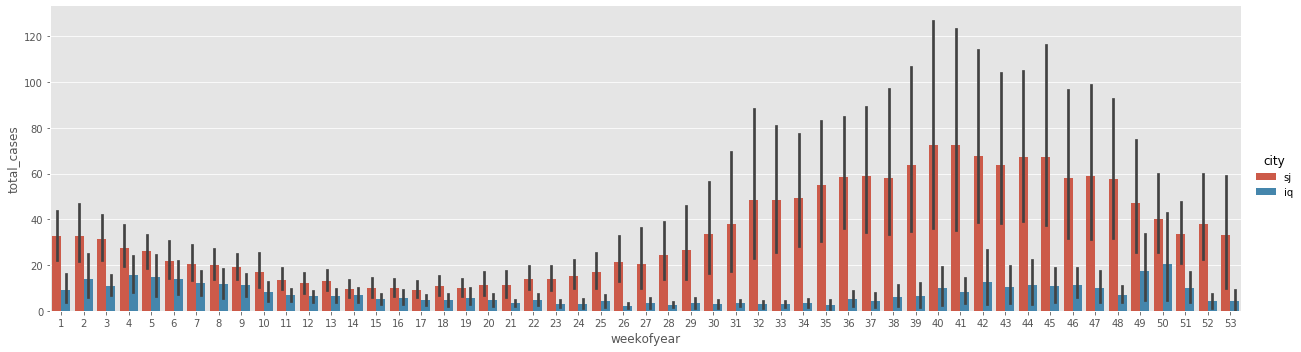

In [10]:
#By visualizing the target variable by the weekofyear and city, you can see some pattern in the data
sns.catplot('weekofyear', 'total_cases',hue='city', data = target, kind='bar', aspect=3.5)

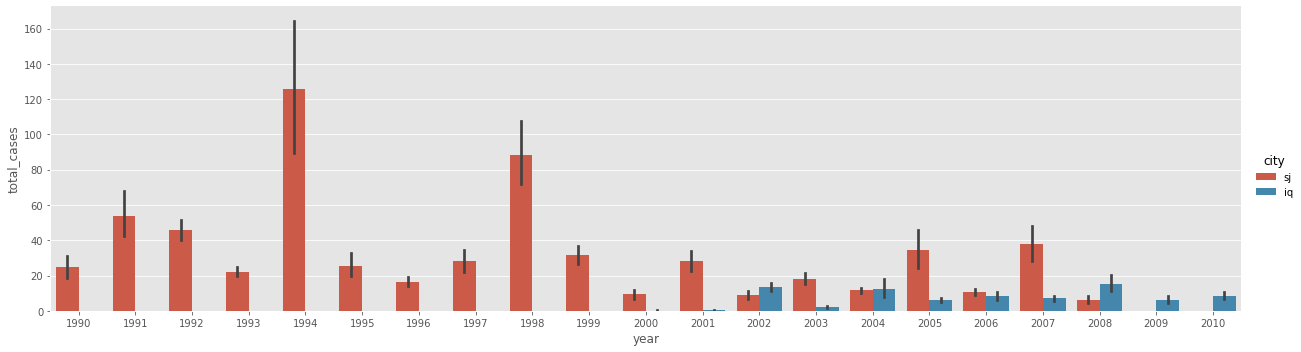

In [11]:
#Same with year and city
sns.catplot('year', 'total_cases', data = target, kind='bar', hue = 'city', aspect=3.5)

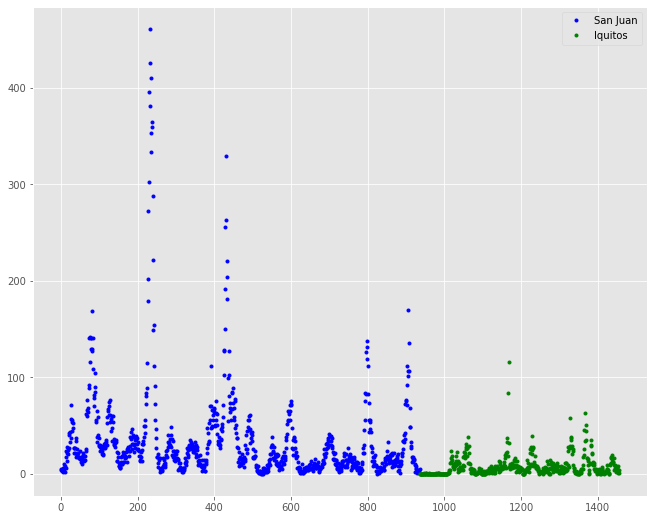

In [12]:
#Since San Juan had noticably more data than Iquitos, I decided not to include it in our model
#Conditions in San Juan and Iquitos should be fairly similar
#Cases over time
#This first time series plot plots one event at each dot
#You can see that cases in Iquitos are a little more condensed even though there is less data
#There is a periodic trend probably due to the weather at certain times of the year
plt.figure(figsize=(11,9))
plt.plot(sj['total_cases'], '.b', label="San Juan", color='b')
plt.plot(iq['total_cases'], '.b', label="Iquitos", color='g')
plt.legend()

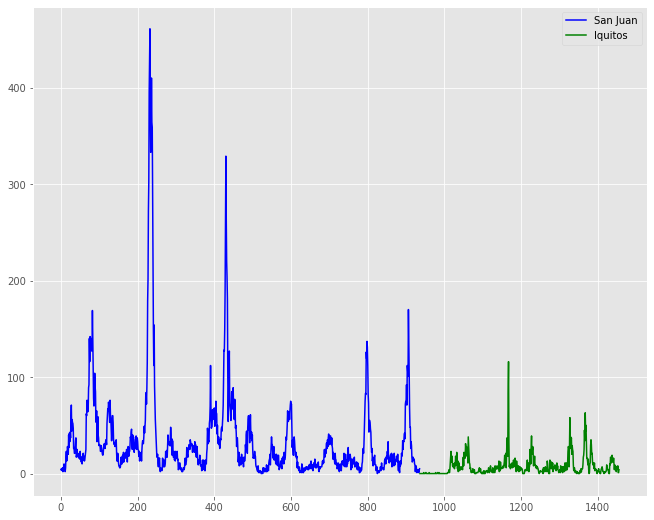

In [13]:
plt.figure(figsize=(11,9))
plt.plot(sj['total_cases'], label="San Juan", color='b')
plt.plot(iq['total_cases'], label="Iquitos", color='g')
plt.legend()

In [14]:
#Displaying the shape of the San juan dataframe before feature extraction
sj.shape

(936, 22)

In [15]:
sj_X = sj


In [16]:
#Orthogonal linear transformation that transforms the data into a new coordinate system
#Center each data point to orgin by subtracting each mean from the dataset
#Performing Principal Component Analysis to find best features
#Calculates data correlation matrix for original data
#Normalize each variable's mean
#dimensionality reduction
from sklearn import decomposition
pca = decomposition.PCA()
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
sj_pca = pca.fit_transform(sj_X)

In [18]:
pca.explained_variance_ratio_

array([5.33329771e-01, 2.92461731e-01, 9.69473569e-02, 5.36484118e-02,
       2.14276808e-02, 1.34958976e-03, 5.25903836e-04, 1.66794820e-04,
       6.40218221e-05, 3.66735202e-05, 1.77316164e-05, 8.79066188e-06,
       6.46434261e-06, 5.55434701e-06, 1.55056182e-06, 6.62021318e-07,
       5.58566032e-07, 3.91778029e-07, 2.79706457e-07, 6.15484744e-08,
       1.96171168e-08, 3.26703983e-33])

In [19]:
pca = decomposition.PCA(n_components=10)
sj_X_prime = pca.fit_transform(sj_X)
sj_X_prime.shape

(936, 10)

In [20]:
#99 percent of the data can be explained by the first 10 features
pca.explained_variance_ratio_.sum()

0.9999579352328274

# https://www.ncdc.noaa.gov/cdr

The results will provide trustworthy information on how, where and to what extent the land, oceans, atmosphere and ice sheets are changing. In turn, this information will be used by energy, water resources, agriculture, human health, national security, coastal community and other interest groups. Our CDR data will improve the Nation's resilience to climate change and variability, maintain our economic vitality and improve the security and well-being of the public.

In [21]:
#Weekofyear and ndvi_ne - CDR Normalized difference vegatation index, northeast of city centroid
sj_X.iloc[:, 0:10]

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k
0,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8
1,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9
2,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5
3,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4
4,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9
...,...,...,...,...,...,...,...,...,...,...
931,13,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7
932,14,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8
933,15,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4
934,16,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7


# Regression

In [70]:
#Splitting the data into train, test data to be fitted for our model
X = sj_X_prime
y = sj.total_cases

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [72]:
#Scaling data to improve computing time
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=True)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [73]:
#fitting the train test split to linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [74]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
pred =lr.predict(X_test)

In [83]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [85]:
print(sklearn.metrics.r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.9970551933502658
7.634186279670359


No handles with labels found to put in legend.


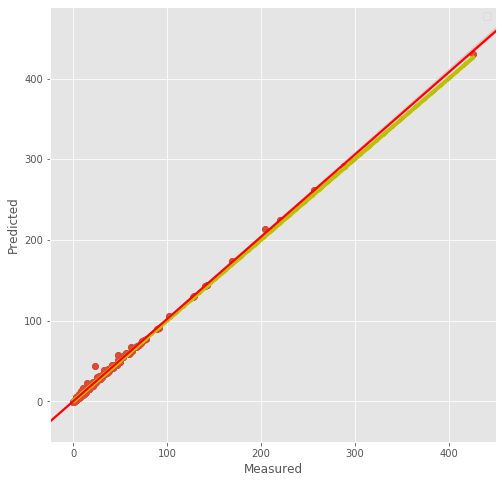

In [86]:
#Visualizing the accuracy of the model compared to the real data, the red line is the predicted and the yellow is the actual
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, pred, edgecolors=(0, 0, 0))
ax.plot(y_test, y_test, 'k--', lw=4, color='y')
sns.regplot(x=y_test, y=pred, ax=ax, line_kws={"color": "red"})
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.legend()

In [87]:
#Fitting the data to a decision tree using the mean squared error as the accuracy metric
from sklearn.ensemble import RandomForestRegressor
rft = RandomForestRegressor()
rft.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [88]:
from sklearn.metrics import mean_squared_error
y_pred = rft.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(sklearn.metrics.r2_score(y_test, y_pred))

14.414361702127655
0.9944398123602071


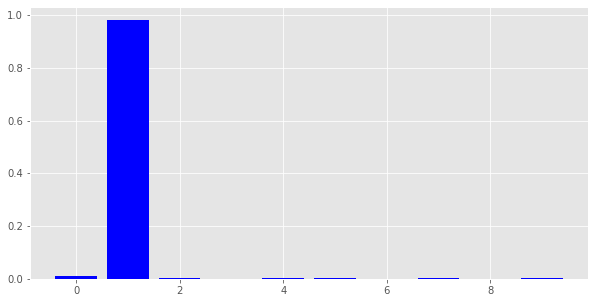

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_rects = ax.bar(np.arange(10), rft.feature_importances_, color='b')
ax.xaxis.set_ticks = np.arange(10)

In [90]:
#It looks like the most important feature is ndvi_ne
sj_X.iloc[:, 0:2]

,weekofyear,ndvi_ne
0,18,0.122600
1,19,0.169900
2,20,0.032250
3,21,0.128633
4,22,0.196200
...,...,...
931,13,0.077850
932,14,-0.038000
933,15,-0.155200
934,16,0.001800


# Classification

In [91]:
#I wanted to try and split the data between the two cities and see if there were noticable differences in the measurements,
#enough to differentiate between the two city

In [92]:
#These numbers and next two plots could have a few different interperations - compare these numbers to histogram and density plot
#1. The rate of infections - there is more data available for San Juan
#2. The ability for each city to manage dengue fever
#3. Maybe San Juan had better control measures to control the spread of the disease
#4. The population and how isolated the city is from surrounding areas
sj['total_cases'].std()

51.38137249715158

In [37]:
iq['total_cases'].std()

10.765478342208679

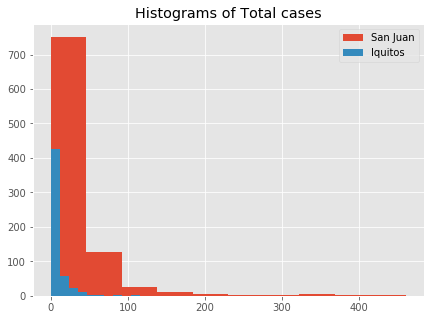

In [38]:
#Checking the data distribution of total cases for each city
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Histograms of Total cases')
ax.hist(sj['total_cases'], label='San Juan')
ax.hist(iq['total_cases'], label='Iquitos')
ax.legend()

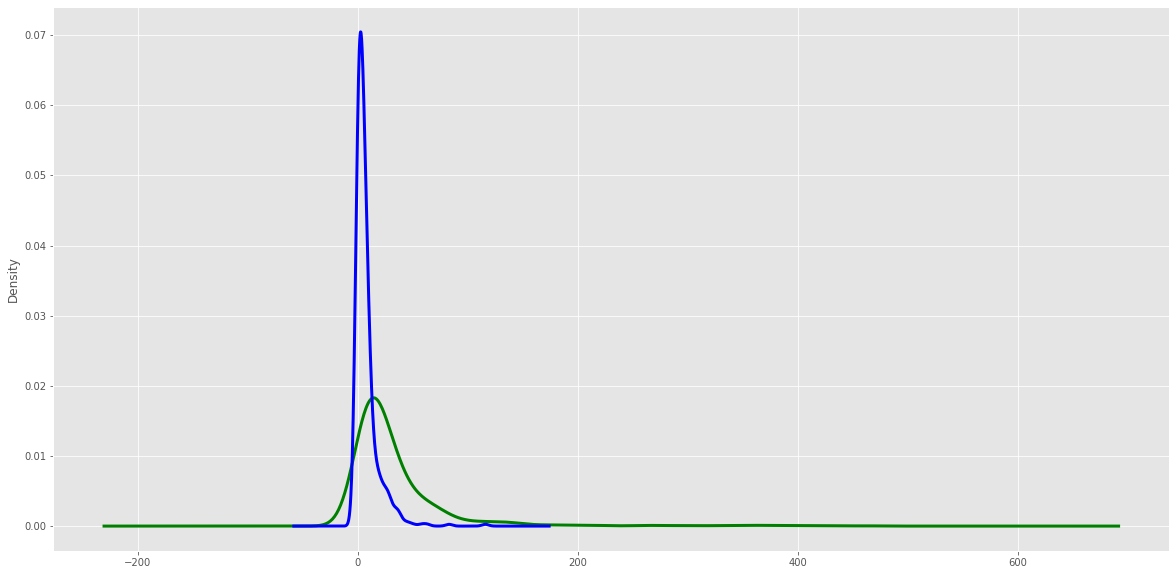

In [39]:
plt.figure(figsize=(20,10))
sj['total_cases'].plot(linewidth=3.0,kind='kde', color='green')
iq['total_cases'].plot(linewidth=3.0,kind='kde', color='blue')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [136]:
df.fillna(method='ffill', inplace=True)

In [137]:
#Splitting data into predictors and target
X = df[['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']]
y = df['city']

In [138]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [139]:
le.fit_transform(y)

array([1, 1, 1, ..., 0, 0, 0])

In [140]:
y

0       sj
1       sj
2       sj
3       sj
4       sj
        ..
1451    iq
1452    iq
1453    iq
1454    iq
1455    iq
Name: city, Length: 1456, dtype: object

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [143]:
#Fitting data to a logistic regression model
#Logistic regression is a classification model
#I used class_weight='balanced' so San Juan wouldn't overpower Iquitos
#I decided to use ridge regulaization because I already performed feature selection with Principal Component Analysis
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(penalty='l2', random_state=0, class_weight='balanced')

In [144]:
logR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
predictions = logR.predict(X_test)

In [146]:
#The model correctly predicted cases in Iquitos 83% 0f the time
#The model correctly predicted cases in San Juan 93% of the time
#Recall - how close all predicted values were to each other

from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          iq       0.83      0.89      0.86       161
          sj       0.93      0.89      0.91       276

    accuracy                           0.89       437
   macro avg       0.88      0.89      0.88       437
weighted avg       0.89      0.89      0.89       437



In [196]:
from sklearn.metrics import multilabel_confusion_matrix

In [197]:
#I don't know how to interpret the confusion matrix in this case
#143 - true positive - 143 cases were correctly classified for San Juan when cases were present
#246 - true positive - 246 cases were correctly classified for Iquitos when cases were present
#Confusion matrix is for both city
#TPR - 93% 
#TPR - 82% 
print(multilabel_confusion_matrix(y_test, predictions))

[[[246  30]
  [ 18 143]]

 [[143  18]
  [ 30 246]]]


In [178]:
#K Nearest Neighbors
#P=2 - Euclidean
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [179]:
test_preds = clf.predict(X_test)

In [185]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, test_preds)

array([[[228,  48],
        [ 16, 145]],

       [[145,  16],
        [ 48, 228]]], dtype=int64)

In [181]:
print("Precision:",sklearn.metrics.precision_score(y_test, test_preds, pos_label='iq'))

Precision: 0.7512953367875648


In [182]:
print("Precision:",sklearn.metrics.precision_score(y_test, test_preds, pos_label='sj'))

Precision: 0.9344262295081968


In [154]:
#Support Vector Classifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

In [155]:
svm_est = Pipeline([('scaler', StandardScaler()), ('svc', OneVsRestClassifier(SVC()))])

In [156]:
#Gamma - determines how influential a single example can be per units of distance
#Low gamma - example have an influence at long distances
#C - a low C makes the decision smoother - less correct
Cs=[0.001, 0.01,0.1,1,10]
gammas = [0.001, 0.01,0.1,1,10]

In [157]:
param_grid = dict(svc__estimator__gamma=gammas, svc__estimator__C=Cs)

In [158]:
#Combinatorial grid search
#Parameters are not independent of eachother
#Combines cross validation with grid search of best parameters
from sklearn.model_selection import RandomizedSearchCV
#Cross-validator
#Randomized folds
#The cross-validation object is a mix between stratifiedkfold and shufflesplit
#Data can and will overlap between folds 
#Shuffles with replacement
from sklearn.model_selection import StratifiedShuffleSplit

In [186]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
rand_grid = RandomizedSearchCV(svm_est, param_distributions=param_grid, cv=cv,n_iter=10)
rand_grid.fit(X_train, y_train)
svc_preds = rand_grid.predict(X_test)
rand_grid.best_params_

{'svc__estimator__gamma': 0.01, 'svc__estimator__C': 10}

In [187]:
#Mean cross-validated score for the best estimator
rand_grid.best_score_

0.8823529411764706

In [188]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, svc_preds)

array([[[252,  24],
        [ 23, 138]],

       [[138,  23],
        [ 24, 252]]], dtype=int64)

LR: 0.843137 (0.115772)
KNN: 0.846769 (0.082887)
SVM: 0.682952 (0.353103)


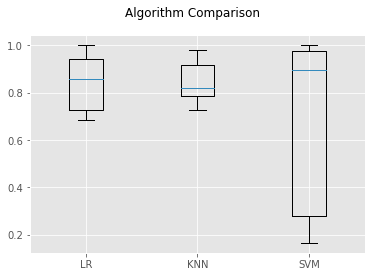

In [201]:
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# For me to determine the right threshold to use I need more data on the healthcare systems, their ability to deal with cases, poverty and sanitation data and data on different control measures . After plotting where San Juan and Iquitos are located relative to eachother, some features of importance may be different between them.